In [1]:
import torch
import pandas as pd
from main import Results
import matplotlib.pyplot as plt
from collections import namedtuple


def clean(summary):
    epoch = summary['test/accuracy'][0].step
    test_accuracy = summary['test/accuracy'][0].value
    robustness = summary['test/robustness'][0].value
    variances = [v.value for v in summary['test/robustness/variances']]
    accuracies = [v.value for v in summary['test/robustness/accuracies']]
    learning_rate = [v.value for v in summary['learning_rate'] if v.step <= epoch]
    wall_times = [v.time for v in summary['train/loss'] if v.step <= epoch]
    times = [t1 - t2 for t1, t2 in zip(wall_times[1:], wall_times[:-1])]
    clean_summary = {
        'epoch': epoch,
        'test_accuracy': test_accuracy,
        'robustness': robustness,
        'variances': variances,
        'accuracies': accuracies,
        'learning_rate': learning_rate,
        'times': times,
    }
    return clean_summary

## Performance comparison for training with augmentation vs training with the expectation

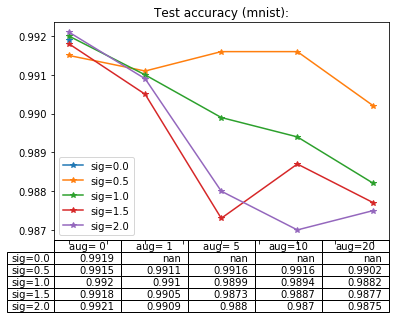

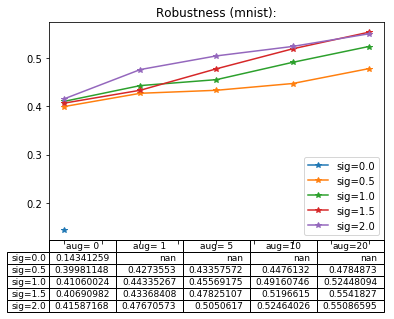

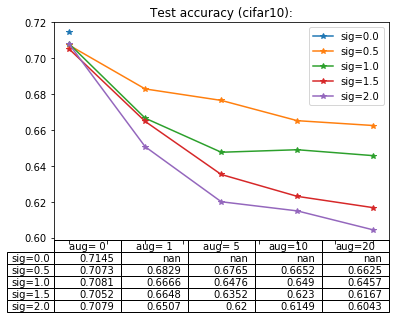

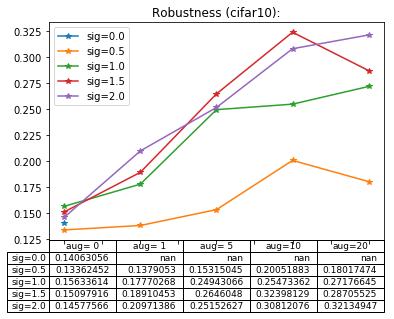

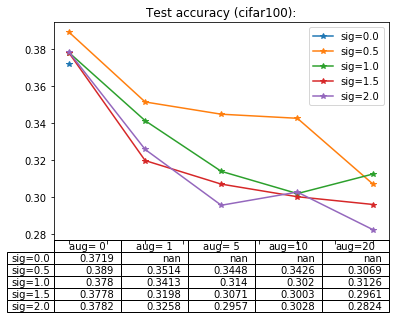

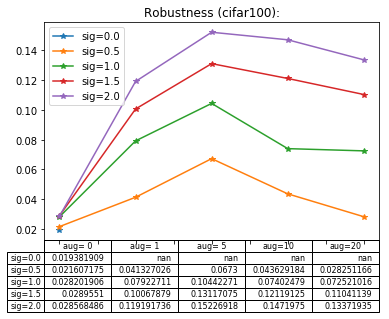

In [2]:
def aug_vs_exp(dataset, verbose=True):
    res = namedtuple('res', ('aug', 'sig', 'acc', 'rob'))
    i = 0
    best = {}
    best_value = {}
    results = []
    for result in Results.all_results():
        if result['dataset'] != dataset:
            continue
        result['summary'] = clean(result['summary'])
        aug = result['aug']
        sig = result['sig']
        acc = result['summary']['test_accuracy']
        rob = result['summary']['robustness']
        if aug == 0:
            if sig not in best or best_value[sig] < acc:
                best[sig] = i
                best_value[sig] = acc
        results.append(res(aug, sig, acc, rob))
        i += 1

    augs = sorted(set(a.aug for a in results))
    sigs = sorted(set(a.sig for a in results))
    
    def extract(attr):
        out = torch.zeros(len(augs), len(sigs)) / 0
        for i, result in enumerate(results):
            value = getattr(result, attr)
            if result.aug == 0 and i != best[result.sig]:
                continue
            index = (augs.index(result.aug), sigs.index(result.sig))
            out[index] = value

        df = pd.DataFrame(out.numpy(),
                          columns=[f'sig={v}' for v in sigs],
                          index=[f'aug={v:2d}' for v in augs])
        return df
    
    acc = extract('acc')
    rob = extract('rob')
    if verbose:
        acc.plot(title=f'Test accuracy ({dataset}):', table=True, style='*-')
        rob.plot(title=f'Robustness ({dataset}):', table=True, style='*-')
    return acc, rob

mnist = aug_vs_exp('mnist')
cifar10 = aug_vs_exp('cifar10')
cifar100 = aug_vs_exp('cifar100')